### **Import Libraries**

In [1]:
from datasets import load_dataset 
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset
import warnings
from functools import partial
from datasets import concatenate_datasets, DatasetDict
from functools import partial 
from IPython.display import display
from IPython.display import Markdown
import textwrap
from transformers import pipeline
from trl import SFTTrainer
# Filter out the specific warning
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')

#### **Plotting**

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')
from matplotlib import font_manager 
locations =  './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-Regular.ttf


#### **Key Parameters**

In [3]:
# This cell is tagged with `parameters`
model_name = 'distilbert-base-cased'
data_link = 'ppower1/instrument'
casusal_variable = True 
column = 'text'
num_epochs = 10
seed = 2 
test_size = 0.5

#### **Helper Functions**

In [4]:
def slice_text(examples, column='text'):
    return {'text': examples[column][:10], 'label': 0 if examples['text'].startswith('No') else 1}

def preprocess_function(examples, column='text'):
    tokenized = tokenizer(examples[column], truncation=True, padding='max_length')
    return {**tokenized, 'label': examples['label']}


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### ---         Memory Check
def Memory():
    print("Current memory usage:")
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
### ---

def add_is_train_column(batch):
    # Length of the batch
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    # Create a list with the same value for all elements in the batch
    batch['is_train'] = [1] * batch_size
    return batch

# Modify the function for the test set
def add_is_test_column(batch):
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    batch['is_train'] = [0] * batch_size
    return batch

def remove_substring(example):
    # The string to be removed
    substring1 = "True or False: The Right to Counsel is in effect in the tenant's zip code."
    substring2 = "True or False: The tenant has legal representation."
    # Replace the substring with an empty string
    example["text"] = example["text"].replace(substring1, "")
    example["text"] = example["text"].replace(substring2, "")

    try:
        example["treated text"] = example["treated text"].replace(substring1, "")
        example["treated text"] = example["treated text"].replace(substring2, "")
        example["control text"] = example["control text"].replace(substring1, "")
        example["control text"] = example["control text"].replace(substring2, "")
    
    except KeyError as e:
        assert casusal_variable == False 


    return example

### ---         Print Markdown
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))
### ---

#### **Model**

In [5]:
Memory()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)
Memory()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Current memory usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Current memory usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
import pandas as pd
unmasker = pipeline('fill-mask', model='roberta-base')
display(pd.DataFrame(unmasker("The white tenat was evicted because she <mask>.")))
display(pd.DataFrame(unmasker("The black tenat was evicted because she <mask>.")))

,score,token,token_str,sequence
0,0.105842,20934,objected,The white tenat was evicted because she objected.
1,0.089837,7311,complained,The white tenat was evicted because she compla...
2,0.070737,3179,refused,The white tenat was evicted because she refused.
3,0.060797,17278,protested,The white tenat was evicted because she protes...
4,0.050921,19894,smoked,The white tenat was evicted because she smoked.


,score,token,token_str,sequence
0,0.067677,20934,objected,The black tenat was evicted because she objected.
1,0.065904,3179,refused,The black tenat was evicted because she refused.
2,0.063993,19894,smoked,The black tenat was evicted because she smoked.
3,0.060058,7311,complained,The black tenat was evicted because she compla...
4,0.054462,2075,ran,The black tenat was evicted because she ran.


In [9]:
original_dataset[label] == 1]


NameError: name 'label' is not defined

In [21]:
type(original_dataset['label'] )

list

In [23]:
idx = np.array(original_dataset['label']) == 1

In [24]:
# Load Dataset 
original_dataset = load_dataset(data_link)['train']
#original_dataset = original_dataset.map(slice_text)
original_dataset['text'][idx]

TypeError: only integer scalar arrays can be converted to a scalar index

#### **Load Data**

In [7]:
# Load Dataset 
original_dataset = load_dataset(data_link)['train']
original_dataset = original_dataset.map(slice_text)
print(np.mean(original_dataset['label']))

# Shuffle the dataset
original_dataset = original_dataset.shuffle(seed=3)

# Select the first 1000 samples
original_dataset = original_dataset.select(range(200))
print(np.mean(original_dataset['label']))

# Remove Unnecessary Trailing String
original_dataset = original_dataset.map(remove_substring)
print(original_dataset)

# Add Index Column
original_dataset = original_dataset.add_column("original_index", range(len(original_dataset)))

# Split Data Set
dataset = original_dataset.train_test_split(test_size=test_size, seed=seed)

# Mark each dataset with train/test ids
dataset['train'] = dataset['train'].map(add_is_train_column, batched=True)
dataset['test'] = dataset['test'].map(add_is_test_column, batched=True)

# Tokenize Dataset 
tokenized_dataset = dataset.map(partial(preprocess_function, column=column), batched=True)

# Combine and Resort Train/Test data sets
combined_dataset = concatenate_datasets([dataset['train'], dataset['test']])
combined_dataset = combined_dataset.sort("original_index")

# Tokenize the combined dataset
tokenized_original_dataset = combined_dataset.map(partial(preprocess_function, column=column), batched=True)
tokenized_treated_dataset = combined_dataset.map(partial(preprocess_function, column='treated text'), batched=True)
tokenized_control_dataset =  combined_dataset.map(partial(preprocess_function, column='control text'), batched=True)

0.2997856486679596
0.35
Dataset({
    features: ['text', 'treated text', 'control text', 'raw_label', 'label'],
    num_rows: 200
})


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

#### **Hyperparameters**

In [8]:
metric = evaluate.load("accuracy")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-4,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        load_best_model_at_end=True,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        optim="adamw"
        #lr_scheduler_type='' #  https://stackoverflow.com/questions/77792137/how-to-fix-the-learning-rate-for-huggingface%C2%B4s-trainer
)

In [9]:
# To get the initial training loss
model.eval()
trainer = SFTTrainer(model=model,
                args=get_training_args("test_trainer"),
                train_dataset=tokenized_dataset["train"],
                eval_dataset=tokenized_dataset["train"],
                compute_metrics=compute_metrics)

init_train_eval = trainer.evaluate()
init_train_loss = init_train_eval['eval_loss']
init_train_accuracy = init_train_eval['eval_accuracy']
print(f"Initial Training Loss: {init_train_loss:.4f}    |   Initial Training Accuracy: {init_train_accuracy:.4f}")

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Initial Training Loss: 0.6610    |   Initial Training Accuracy: 0.6800


In [10]:
# Actual Trainer
model.eval()
trainer = Trainer(
                model=model,
                args=get_training_args('output_dir'),
                train_dataset=tokenized_dataset["train"],
                eval_dataset=tokenized_dataset["test"],
                compute_metrics=compute_metrics)

init_eval_eval = trainer.evaluate()
init_eval_loss = init_eval_eval['eval_loss']
init_eval_accuracy = init_eval_eval['eval_accuracy']
print(f"Initial Evaluation Loss: {init_eval_loss:.4f}    |   Initial Evaluation Accuracy: {init_eval_accuracy:.4f}")

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Initial Evaluation Loss: 0.6731    |   Initial Evaluation Accuracy: 0.6200


In [11]:
# Train
model.train()
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.493900,2.289952,0.620000


TrainOutput(global_step=40, training_loss=0.8087713897228241, metrics={'train_runtime': 31.9738, 'train_samples_per_second': 31.276, 'train_steps_per_second': 1.251, 'total_flos': 132467398656000.0, 'train_loss': 0.8087713897228241, 'epoch': 10.0})

In [12]:
steps, train_loss = [0] + [i['step'] for i in trainer.state.log_history if 'loss' in i], [init_train_loss] + [i['loss'] for i in trainer.state.log_history if 'loss' in i]
_, eval_loss = [i['step'] for i in trainer.state.log_history if 'eval_loss' in i], [init_eval_loss] + [i['eval_loss'] for i in trainer.state.log_history if 'eval_loss' in i]
eval_accuracy = [init_eval_accuracy] + [i['eval_accuracy'] for i in trainer.state.log_history if 'eval_accuracy' in i]
lr = [i['learning_rate'] for i in trainer.state.log_history if 'learning_rate' in i]

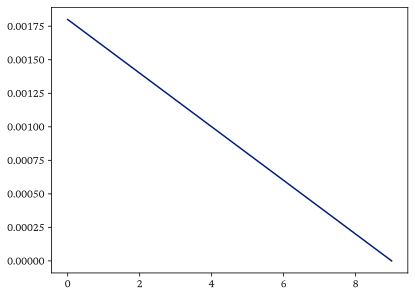

In [13]:
plt.plot(lr)
plt.show()

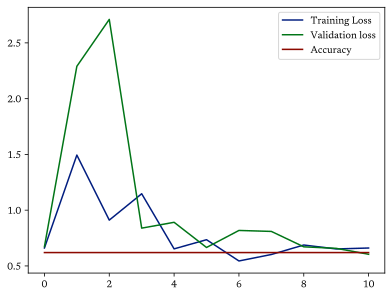

In [14]:
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation loss')
plt.plot(eval_accuracy, label='Accuracy')
plt.legend()
plt.show()

In [29]:
original_dataset[:10]

{'text': ['No, the Ri',
  'No, the Ri',
  'Yes, the R',
  'No, the Ri',
  'Yes, the R',
  'No, the Ri',
  'Yes, the R',
  'No, the Ri',
  'No, the Ri',
  'No, the Ri'],
 'treated text': ["Yes, the Right to Counsel is in effect in the tenant's zip code. The complaint filed by Trudi-Ann Richards against LeQuan Stovall states that the plaintiff and defendant entered into a written lease agreement for a residential premises located at 74 4th Street, Third Floor, Hamden, Connecticut. The lease term began on November 15, 2021, and was set to end on November 14, 2022. The defendant took possession of the premises at the start of the lease term and has remained in possession since then.\n\nHowever, the defendant has failed to make the agreed upon monthly rental payments on time. As a result, on April 12, 2022, the plaintiff terminated the lease and served the defendant with a notice to quit possession of the premises due to nonpayment of rent. The notice to quit, along with the Right to Counse

In [16]:
inputs = tokenizer(original_dataset['text'][0], return_tensors='pt').to('cuda')

In [30]:
original_predictions

array([0.36594826, 0.36594826, 0.42864883, 0.36594826, 0.42864883,
       0.36594826, 0.42864883, 0.36594826, 0.36594826, 0.36594826,
       0.36594826, 0.42864883, 0.36594826, 0.36594826, 0.42864883,
       0.42864883, 0.36594826, 0.36594826, 0.36594826, 0.36594826,
       0.36594826, 0.36594826, 0.42864883, 0.42864883, 0.42864883,
       0.36594826, 0.42864883, 0.36594826, 0.36594826, 0.42864883,
       0.36594826, 0.36594826, 0.36594826, 0.42864883, 0.36594826,
       0.42864883, 0.42864883, 0.42864883, 0.36594826, 0.36594826,
       0.42864883, 0.36594826, 0.36594826, 0.36594826, 0.36594826,
       0.36594826, 0.36594826, 0.36594826, 0.42864883, 0.36594826,
       0.36594826, 0.42864883, 0.36594826, 0.36594826, 0.36594826,
       0.36594826, 0.36594826, 0.36594826, 0.36594826, 0.36594826,
       0.36594826, 0.36594826, 0.36594826, 0.36594826, 0.42864883,
       0.36594826, 0.36594826, 0.36594826, 0.36594826, 0.42864883,
       0.42864883, 0.36594826, 0.42864883, 0.36594826, 0.42864

In [17]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_original_dataset).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()

with torch.no_grad():
    treated_predictions = trainer.predict(tokenized_treated_dataset).predictions
    treated_predictions = torch.nn.functional.softmax(torch.tensor(treated_predictions), dim=1)[:,1].numpy()

with torch.no_grad():
    control_predictions = trainer.predict(tokenized_control_dataset).predictions
    control_predictions = torch.nn.functional.softmax(torch.tensor(control_predictions), dim=1)[:,1].numpy()

In [27]:
treated_predictions - control_predictions

array([ 1.1092424e-03,  2.3855567e-03,  1.4096498e-03,  2.4510026e-03,
        8.9451671e-04,  1.0951161e-03, -1.1551976e-03, -2.4586916e-05,
       -5.7181716e-04, -1.7902255e-04, -2.8070807e-04,  2.4522543e-03,
        1.5751123e-03,  3.3713281e-03,  6.9764256e-04,  2.4866462e-03,
        1.4806390e-03,  1.3495684e-03,  1.1968017e-03,  1.4442503e-03,
        1.4835000e-03,  1.3860166e-03,  7.7545643e-04,  1.8078089e-03,
        4.0964782e-03,  3.7962198e-04, -4.7501922e-04,  1.4640987e-03,
        8.4513426e-04,  1.1545718e-03,  6.3741207e-04,  5.4356456e-04,
        2.7576089e-03,  1.1840463e-03,  2.2521615e-03, -2.8778911e-03,
        1.4351606e-03, -1.3161898e-03,  2.6123822e-03,  1.4658868e-03,
        8.6402893e-04,  4.9912632e-03,  2.2068918e-03,  4.2644143e-04,
        1.4889240e-03,  1.0131896e-03, -8.8566542e-04,  8.4686279e-04,
        1.1777580e-03, -1.6656518e-04,  1.8951297e-04,  1.2398064e-03,
        2.7292073e-03,  1.5826821e-03,  3.5277009e-04, -3.2267570e-03,
      

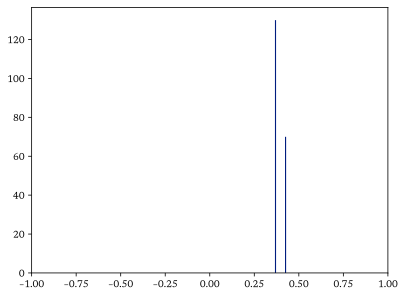

In [20]:
plt.hist(original_predictions)
plt.xlim(-1,1)
plt.show()

In [21]:
results = np.hstack((np.array(tokenized_original_dataset['is_train']).reshape(-1,1), original_predictions.reshape(-1,1), treated_predictions.reshape(-1,1), control_predictions.reshape(-1,1) ))

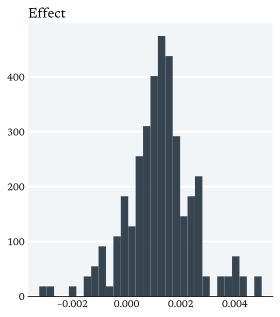

In [22]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Effect', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist((treated_predictions - control_predictions).reshape(-1,), color='#36454F', density=True, bins=30)
plt.show()

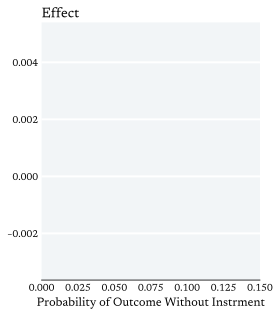

In [23]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Effect', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.scatter(control_predictions.reshape(-1,), (treated_predictions - control_predictions).reshape(-1,), color='#36454F')
plt.xlim(0, .15)
plt.xlabel("Probability of Outcome Without Instrment", size=12)
plt.show()

In [24]:
os.getcwd()

'/home/ubuntu/llmft/notebooks-scripts/encoder'

#### **Clean Up**

In [25]:
!rm -rf ./output_dir

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
!rm -rf ./synth_evict/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
